In [1]:
import sys
import os
import numpy as np
sys.path.append(os.path.abspath(os.path.dirname(os.getcwd())))

from src.utility.h5_serializable_file import H5Serializable
import src.utility.utils as utils 
from uncertainties import ufloat
from src.utility.planet import Planet
from src.utility.run_cfg import ErebusRunConfig
from src.erebus import Erebus
from src.joint_fit import JointFit
from src.wrapped_fits import WrappedFits
from src.photometry_data import PhotometryData
from src.individual_fit import IndividualFit
import glob

In [2]:
cache_files = np.array(glob.glob("erebus_cache/*"))
cache_files = np.array([file.replace('erebus_cache/', '') for file in cache_files])
with_jw_at_start = cache_files[[file.startswith("jw") for file in cache_files]]
observation_names = np.array([file[:len("jw03730")] for file in with_jw_at_start])
observation_names = np.unique(observation_names)
print(observation_names)


['jw01177' 'jw01279' 'jw02304' 'jw03730' 'jw06457']


In [3]:
import matplotlib.pyplot as plt
import inspect
import numpy as np
from src.utility.utils import bin_data
from src.utility.utils import get_eclipse_duration

def plot_joint_fit(joint_fit):
	fp = joint_fit.results['fp'].nominal_value
	fp_err = joint_fit.results['fp'].std_dev
	inc = joint_fit.results["inc"].nominal_value
	a = joint_fit.results["a_rstar"].nominal_value
	rp = joint_fit.results["rp_rstar"].nominal_value
	per = joint_fit.results["p"].nominal_value
	offset = joint_fit.results["t_sec_offset"].nominal_value * 24
	duration = get_eclipse_duration(inc, a, rp, per) * 24
	print("Offset: ", offset, "hours")
	eclipse_start = offset - duration/2
	eclipse_end = offset + duration/2
	
	args = [x.nominal_value for x in list(joint_fit.results.values())]
	number_of_physical_args = len(inspect.getfullargspec(joint_fit.physical_model).args) - 2
	physical_args = args[0:number_of_physical_args]
	number_of_systematic_args = len(inspect.getfullargspec(joint_fit.systematic_model).args) - 2
	visit_indices = np.array([joint_fit.get_visit_index_from_time(xi) for xi in joint_fit.time])
	#for visit_index in range(0, len(joint_fit.photometry_data_list)):
	detrended_visit = []
	time_visit = []
	physical_visit = []
	for visit_index in range(0, len(joint_fit.photometry_data_list)):
		filt = visit_indices == visit_index
		time = joint_fit.time[filt]
		flux = joint_fit.raw_flux[filt]
					
		systematic_index_start = (number_of_physical_args) + (visit_index * number_of_systematic_args)
		systematic_args = args[systematic_index_start:systematic_index_start + number_of_systematic_args]
	
		systematic = joint_fit.systematic_model(time, *systematic_args)
		physical = joint_fit.physical_model(time, *physical_args)
		
		detrended_visit.append(flux / systematic)
		time_visit.append((time - joint_fit.get_predicted_t_sec_of_visit(visit_index).nominal_value - joint_fit.starting_times[visit_index]) * 24)
		physical_visit.append(physical)
	
	for i in range(0, len(joint_fit.photometry_data_list)):
		plt.plot(time_visit[i], detrended_visit[i], linestyle='', marker='.', color='grey', alpha=0.2)
	
	combined_times = np.concatenate(time_visit)
	combined_flux = np.concatenate(detrended_visit)
	sort = np.argsort(combined_times)
	combined_times = combined_times[sort]
	combined_flux = combined_flux[sort]
	
	bin_size = len(combined_times) // 30
	bin_time, _ = bin_data(combined_times, bin_size)
	bin_flux, _ = bin_data(combined_flux, bin_size)
	yerr = joint_fit.results['y_err'].nominal_value
	
	plt.errorbar(bin_time, bin_flux, yerr/np.sqrt(bin_size), color='black', linestyle='', marker='.')
	
	plt.plot(time_visit[0], physical_visit[0], color='red')
	plt.axvspan(eclipse_start, eclipse_end, color='red', alpha=0.2)
	plt.ylabel("Normalized flux")
	plt.xlabel("Time from 0.5 phase (hours)")
	plt.title("Phase folded light curve")
	
	plt.gca().text(0.5, 0.95, f"Eclipse depth: {fp*1e6:0.0f}+/-{fp_err*1e6:0.0f}ppm", horizontalalignment='center', verticalalignment='top', transform=plt.gca().transAxes)
	plt.show()

In [4]:
from src.plotting import plot_fnpca_individual_fit

def get_fits(data_hash, config_hash, planet_file, config_file):	
	def get_photometry_path(visit_name):
		return glob.glob(f"erebus_cache/{visit_name}*{data_hash}*_photometry_data.h5")[0]
	def get_individual_fit_path(visit_name):
		return glob.glob(f"erebus_cache/{visit_name}*{data_hash}*{config_hash}*_individual_fit.h5")[0]
	wrapped_fits_cache = glob.glob(f"erebus_cache/*{data_hash}*_wrapped_fits.h5")
	joint_fit_cache = glob.glob(f"erebus_cache/*{data_hash}*{config_hash}*_joint_fit.h5")[0]
	
	planet = Planet(f"../reanalysis_2025/planets/{planet_file}")
	config = ErebusRunConfig.load(config_file)
	fits = [WrappedFits(None, None, override_cache_path = path) for path in wrapped_fits_cache]
	photometry = [PhotometryData(fit, 5, (12, 20), override_cache_path = get_photometry_path(fit.visit_name)) for fit in fits]
	individual_fits = [IndividualFit(p, planet, config, override_cache_path = get_individual_fit_path(p.visit_name)) for p in photometry]
	joint_fit = JointFit(photometry, planet, config, override_cache_path = joint_fit_cache)
	return individual_fits, joint_fit

def plot_fits(data_hash, config_hash, planet_file, config_file):
	individual_fits, joint_fit = get_fits(data_hash, config_hash, planet_file, config_file)
	for fit in individual_fits:
		if 'fp' not in fit.results:
			print("Fit didn't run")
		else:
			plot_fnpca_individual_fit(fit, show=True)
			plt.show()
	if 'fp' not in joint_fit.results:
		print("Joint fit didn't run")
	else:
		return
		plot_joint_fit(joint_fit)

Circular orbit: using gaussian prior for t_sec
Predicted t_sec: 0.0879+/-0.0004
Circular orbit: using gaussian prior for t_sec
Predicted t_sec: 0.0886+/-0.0004
Circular orbit: using gaussian prior for t_sec_offset


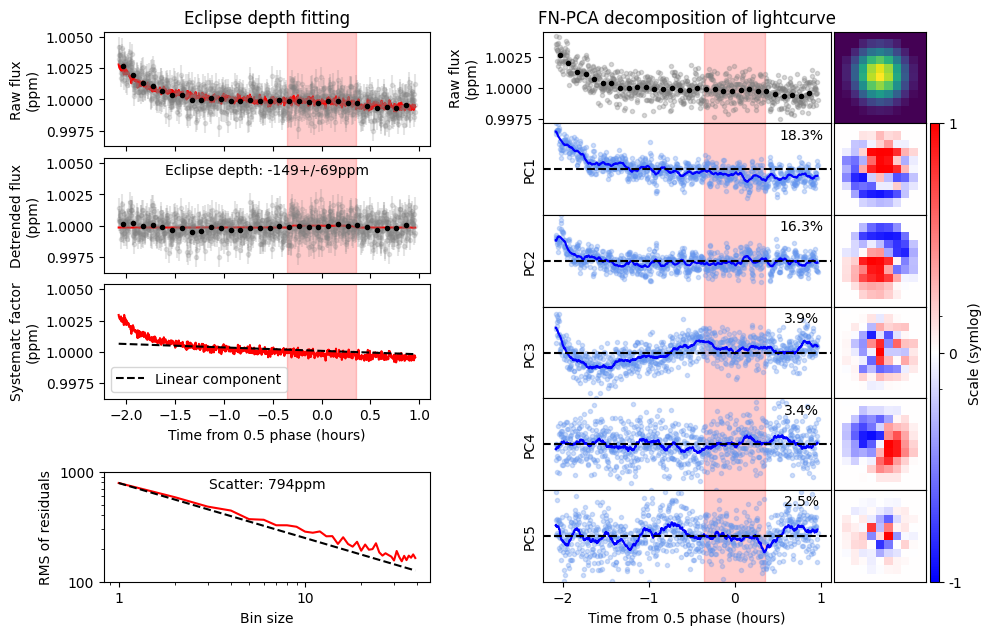

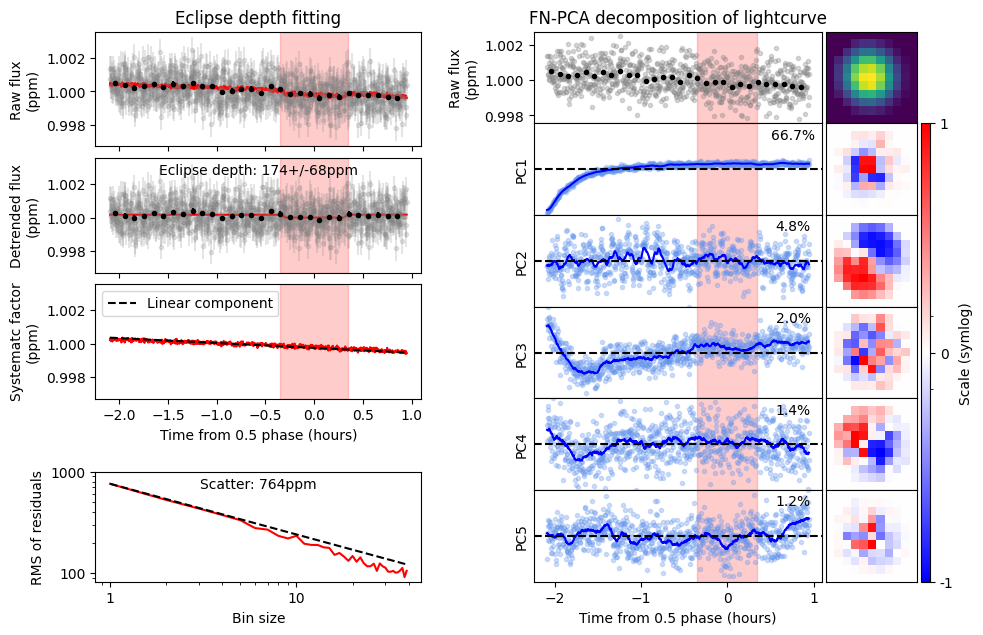

In [5]:
#jw03730013001_9df3ebc8b16bb90e6e80da5cab6f8b2f_0637e8ca1db2b15585bd4954bb838d44_individual_fit

plot_fits("9df3ebc8b16bb90e6e80da5cab6f8b2f", "0637e8ca1db2b15585bd4954bb838d44", "lhs1478b.yaml", "lhs1478b.yaml")

In [6]:
individual_fits, joint_fit = get_fits("9df3ebc8b16bb90e6e80da5cab6f8b2f", "0637e8ca1db2b15585bd4954bb838d44", "lhs1478b.yaml", "lhs1478b.yaml")

Circular orbit: using gaussian prior for t_sec
Predicted t_sec: 0.0879+/-0.0004
Circular orbit: using gaussian prior for t_sec
Predicted t_sec: 0.0886+/-0.0004
Circular orbit: using gaussian prior for t_sec_offset


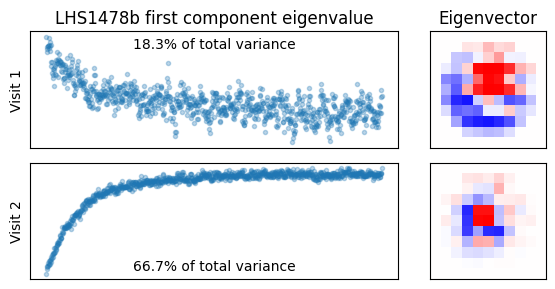

In [63]:
import matplotlib.colors as colors

fig, axs = plt.subplots(2,2, gridspec_kw={'width_ratios': [2, 1]}, figsize=(6, 3), sharex='col')

t = individual_fits[0].time
val1 = individual_fits[0].eigenvalues[0] * 1e6
val2 = individual_fits[1].eigenvalues[0] * 1e6

vec1 = individual_fits[0].eigenvectors[0]
vec1 /= np.max(np.abs(vec1))

vec2 = individual_fits[1].eigenvectors[0]
vec2 /= np.max(np.abs(vec2))

axs[0,0].plot(t, val1, marker='.', alpha=0.3, linestyle='')
eigenvalue_ax = axs[0,0]
eigenvalue_ax.text(0.5, 0.95, f"{individual_fits[0].pca_variance_ratios[0]*100:0.1f}% of total variance", horizontalalignment='center', verticalalignment='top', transform=eigenvalue_ax.transAxes)

axs[0,1].imshow(vec1, cmap='bwr', interpolation='nearest', norm = colors.SymLogNorm(0.5, vmin=-1, vmax=1))
axs[0,1].set_yticks([])
axs[0,1].set_xticks([])
axs[0,0].set_ylabel("Visit 1")

axs[1,0].plot(t, val2, marker='.', alpha=0.3, linestyle='')
eigenvalue_ax = axs[1,0]
eigenvalue_ax.text(0.5, 0.05, f"{individual_fits[1].pca_variance_ratios[0]*100:0.1f}% of total variance", horizontalalignment='center', verticalalignment='bottom', transform=eigenvalue_ax.transAxes)


axs[1,1].imshow(vec2, cmap='bwr', interpolation='nearest', norm = colors.SymLogNorm(0.5, vmin=-1, vmax=1))
axs[1,1].set_yticks([])
axs[1,1].set_xticks([])
axs[1,0].set_ylabel("Visit 2")

axs[1,0].set_xticks([])
axs[1,0].set_yticks([])
axs[0,0].set_yticks([])


axs[0,0].set_title("LHS1478b first component eigenvalue")
axs[0,1].set_title("Eigenvector")

plt.tight_layout()
plt.savefig("LHS1478b eigenvalue slopes.pdf")